# Freundlich & Maoz (2020): The delay time distribution of Type-Ia supernovae in galaxy clusters: the impact of extended star-formation histories

# 1/ PARAMETERS AND DATA

In [16]:
import os, sys
import numpy as np
import emcee
import pickle
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad, simps
from scipy.special import gamma, gammainc
import math
import random
import scipy.constants as constants
from scipy.constants import *
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import pickle
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d

################################################################################

# COSMOLOGY

Omega_m = 0.30 
Omega_l = 1.-Omega_m
H0      = 70. #km/s/Mpc
dH      = c*1.e-3/H0 #Mpc

def integrand(zz):
    return 1./np.sqrt(Omega_m*(1.+zz)**3+Omega_l)

def d_comoving(zz): #Mpc
    return dH*quad(integrand, 0., zz, epsabs=1.e-06)[0]

def d_luminosity(zz): #Mpc
    return d_comoving(zz)*(1.+zz)

def d_angular(zz): #Mpc
    return d_comoving(zz)/(1.+zz)
    
def d_scale(zz):
    return d_angular(zz)*1e3*4.84814e-6 # kpc/arcsec

def t_cosmic(z,h=0.7,Om=0.3,OL=0.7):
    fac = OL / (1.+z)**3
    return (9.778/h) * 2./(3.*np.sqrt(OL)) * \
        np.log((np.sqrt(fac)+np.sqrt(fac+Om)) / np.sqrt(Om))

################################################################################

#Pégase.3 modules:

sys.path.append('./pegase/python_dir')
import mod_read_spectra_output as mrso
import mod_interp as mi
import mod_input_util as miu
import mod_directories as md

################################################################################

# Additional modules 

execfile('./python/plot_chi2.py')
execfile('./python/extinction.py')
execfile('./python/corner.py')


Define extinction


In [19]:
# OBSERVATIONAL DATA

name_old=np.array(['IDCS1426', 'IDCS1432', 'MOO1014', 'MOO1142', 'SPARCS0224','SPARCS0330', 'SPARCS1049', 'SPARCS3550', 'SPT0205', 'SPT2040','SPT2106', 'XMM44'])
name=np.array(['IDCS1426', 'ISCS1432', 'MOO1014', 'MOO1142', 'SPARCS0224','SPARCS0330', 'SPARCS1049', 'SPARCS0035', 'SPT0205', 'SPT2040','SPT2106', 'XMM44'])

F105W=np.array([0.50, 0.70, 2.15, 2.31, 1.00, 0.90, 1.30, 1.28, 0.90 , 1.43, 3.55, 1.30  ])
dF105W=np.array([0.45, 0.18, 0.21, 0.15, 0.30, 0.21, 0.25  , 0.25  , 0.25  , 0.35, 0.30, 0.10])

F140W=np.array([0.68, 0.97, 1.95, 2.11, 0.89, 1.02,  np.nan, 1.22, 1.14, 2.13, 1.98, 1.32])
dF140W=np.array([0.10, 0.06, 0.25, 0.15, 0.16, 0.20,  np.nan, 0.18, 0.13, 0.23, 0.13, 0.08])

F160W=np.array([0.53, 0.81, 1.38,  np.nan, 0.67, 0.55, 0.80,  np.nan, 1.09, 1.11,  np.nan, 1.15])
dF160W=np.array([0.11, 0.11, 0.17,  np.nan, 0.26, 0.15, 0.14,  np.nan, 0.11, 0.30,  np.nan, 0.13])

N_obs=np.array([1.5,1.,2.,0.,1.5,0.5,0.,0.5,4.5,3.,1.,1.])
dN_obs=np.array([.5,0.,0.,0.,.5,0.5,0.,0.5,.5,0.,0.,0.])

t1   =np.array([1.5, 2.3, 2.7, 3. , 1.8, 1.8, 1.6, 2.5, 2.6, 2.1, 3.2, 1.9]) # Gyr
t2   =np.array([2.1, 2.9, 3.3, 3.6, 2.4, 2.4, 2.2, 3.1, 3.2, 2.7, 3.7, 2.5]) # Gyr
z    =np.array([1.75, 1.4 , 1.27, 1.19, 1.63, 1.63, 1.7 , 1.34, 1.32, 1.48, 1.13, 1.58])
Mstar=np.array([0.52, 0.47, 1.45, 1.59, 0.98, 0.48, 0.83, 0.7 , 0.63, 1.27, 1.55,1.27])*1e13
dMstar=np.array([0.18, 0.18, 0.43, 0.55, 0.37, 0.17, 0.38, 0.27, 0.23, 0.55, 0.49, 0.46])*1e13
Nclusters=np.size(name)

DL=np.zeros_like(z)
for i in range(np.size(z)):
	DL[i]=d_luminosity(z[i])
DL_pc=DL*1e6

F_clusters=np.nan*np.ones((Nclusters,3))
F_clusters[:,0]=F105W
F_clusters[:,1]=F140W
F_clusters[:,2]=F160W

dF_clusters=np.nan*np.ones((Nclusters,3))
dF_clusters[:,0]=dF105W
dF_clusters[:,1]=dF140W
dF_clusters[:,2]=dF160W

# Setatau
name_obs =['IDCS1426','IDCS1426','IDCS1432','IDCS1432','MOO1014','MOO1014','MOO1142','SPARCS0224','SPARCS0330','SPARCS1049','SPARCS3550','SPARCS3550','SPT0205','SPT2040','SPT2040','SPT2106','SPT2106','XMM44']
eta40=np.array([0.71,0.78,0.88,0.88,0.93,0.92,0.87,0.72,0.77,0.56,0.89,0.88,0.93,0.85,0.85,0.93,0.95,0.69])
eta00=np.array([0.86,0.87,0.93,0.96,0.99,0.98,0.93,0.83,0.87,0.63,0.95,0.97,0.99,0.96,0.94,0.98,0.98,0.79])
eta20=np.array([0.75,0.79,0.86,0.86,0.89,0.89,0.88,0.81,0.85,0.62,0.87,0.88,0.88,0.91,0.84,0.90,0.91,0.77])
tau_obs=np.array([52,89,104,87,98,88,89,67,112,41,75,45,310,101,42,90,71,70])
z_obs    =np.array([1.75,1.75,1.40,1.40,1.27,1.27,1.19,1.63,1.63,1.70,1.34,1.34,1.32,1.48,1.48,1.13,1.13,1.58]) 

Setatau_obs=np.nan*np.ones(np.size(name_obs)) # year
for igal in range(np.size(name_obs)):
    if igal==0 or name_obs[igal]<>name_obs[igal-1]: 
        Setatau_obs[igal]=(tau_obs[igal]*eta00[igal]+40/(1+z_obs[igal])*eta40[igal]+20/(1+z_obs[igal])*eta20[igal])/365.
    else:
        Setatau_obs[igal-1]+=(tau_obs[igal]*eta00[igal]+40/(1+z_obs[igal])*eta40[igal]+20/(1+z_obs[igal])*eta20[igal])/365.

Setatau=np.array([value for value in Setatau_obs if not math.isnan(value)])

lambda_F160W,filt_F160W = np.loadtxt('./filters/HST_WFC3_IR.F160W.dat'  ,unpack=True)
lambda_F140W,filt_F140W = np.loadtxt('./filters/HST_WFC3_IR.F140W.dat'  ,unpack=True)
lambda_F105W,filt_F105W = np.loadtxt('./filters/HST_WFC3_IR.F105W.dat'  ,unpack=True)
lambda_B,filt_B         = np.loadtxt('./filters/Bband_filter.txt'  ,unpack=True)
lambda_B=lambda_B*10.

In [18]:
# ADD PREVIOUS LOWER T MEASUREMENTS 

previous_ID      = np.array(['B12','GY02','S10','G08','GY02','D10','S07','D10','M08'])
previous_redshift= np.array([1.12, 0.90, 0.60, 0.46, 0.25, 0.23, 0.15, 0.08, 0.02])
previous_tdelay=   np.array([ 3.2,  4.1,  5.7,  6.6,  8.4,  8.7,  9.5, 10.3, 11.1])
previous_tdelay_p= np.array([ 0.9,  0.3,  0.7,  2.3,  0.7,  1.3,  1.0,  0.6,  0.2])
previous_tdelay_n= np.array([ 1.0,  1.4,  1.5,  1.0,  1.1,  0.7,  0.4,  1.0,  0.3])
previous_RIam    = np.array([  20,   12,  8.0,  9.3,  5.7,  4.6,  5.0,  3.0,  3.3])
previous_RIam_p  = np.array([  18,   13,  7.2,  7.2,  8.3,  1.3,  3.4,  1.5,  1.4])
previous_RIam_n  = np.array([  15,    6,  6.1,  6.1,  3.7,  1.0,  2.5,  1.1,  1.0])
previous_RIal    = np.array([0.50, 0.80, 0.35, 0.31, 0.39, 0.33, 0.36, 0.23, 0.28])
previous_RIal_p  = np.array([0.33, 1.06, 0.31, 0.51, 0.90, 0.09, 0.24, 0.11, 0.11])
previous_RIal_n  = np.array([0.28, 0.52, 0.26, 0.16, 0.32, 0.08, 0.16, 0.08, 0.08])

Nprevious=np.size(previous_redshift)

previous_DL=np.zeros_like(previous_redshift)
for i in range(np.size(previous_redshift)):
	previous_DL[i]=d_luminosity(previous_redshift[i])
previous_DL_pc=DL*1e6

# MINIMUM AND MAXIMUM DELAY TIME
previous_t1=t_cosmic(previous_redshift)-t_cosmic(3)
previous_t2=t_cosmic(previous_redshift)-t_cosmic(4)

previous_data=[previous_redshift,previous_t1,previous_t2,previous_RIam,previous_RIam_p,previous_RIam_n,previous_RIal,previous_RIal_p,previous_RIal_n]


In [20]:
# SET GRID

tau_grid=np.linspace(0,1200,13,dtype='int')
tdelay_grid=np.linspace(1.5,11.7,103)
extinction_grid=np.linspace(0,1.5,16)
m2_grid=np.logspace(-4,0,10)

grid=[tau_grid,tdelay_grid,extinction_grid,m2_grid]
limits=[[tau_grid.min(),tau_grid.max()],[tdelay_grid.min(),tdelay_grid.max()],[extinction_grid.min(),extinction_grid.max()],np.log10([m2_grid.min(),m2_grid.max()])]

extinction_model='ccm89' # Cardelli, Clayton, & Mathis (1989)
extinction_rv=3.1

R0_limits=[0.01,5.]
alpha_limits=[-5.,0.]

save_name='output'
save_folder='./%s/'%save_name

if not os.path.exists(save_folder):
    print 'Created ', save_folder
    os.makedirs(save_folder)

Created  ./output/


In [25]:
################################################################################
# LOAD PEGASE FILES

path=os.getcwd()

spectra_files=[]
for i, taui in enumerate(tau_grid):  
    spectra_files.append('JF_grid_Z020_tau%.0f_larget.txt'%(taui/100.))

file_name = list()
for row in spectra_files:
    file_name.append(md.path_file(path+'/pegase/grid_spectra/', row))
    
dim_file = len(file_name)
data = list()

print("dim file " + str(dim_file))
data = list()
for i_file in range(dim_file):
    data.append(mrso.read_spectra_output(file_name[i_file]))
    pass

# SECOND BURST AT t=100 Myr WITH tau=100 Myr

data_burst2=data[1]
i_burst2=np.where(data_burst2.output_age==100.)[0][0]
lum_cont_burst2=data_burst2.lum_cont[i_burst2,:]

################################################################################

dim file 13


In [27]:
# REVISED LOW-Z MEASUREMENTS FROM MAOZ & GRAUR (2017)

name_previous=['B12','GY02','S10','G08','GY02','D10','S07','D10','M08']

t_previous=np.array([3.2,4.1,5.7,6.6,8.4,8.7,9.5,10.3,11.1])
dt_previous_lowerr=np.array([1,1.4,1.5,1,1.1,0.7,0.4,1.,0.3])
dt_previous_upperr=np.array([0.9,0.3,0.7,2.3,0.7,1.3,1.0,0.6,0.2])

R_previous=np.array([20,12,8,9.3,5.7,4.6,5.,3,3.3])*1e-14
dR_previous_lowerr=np.array([15,6,6.1,6.1,3.7,1,2.5,1.1,1])*1e-14
dR_previous_upperr=np.array([18,13,7.2,7.2,8.3,1.3,3.4,1.5,1.4])*1e-14

t_all=2.5054
dt_all=[[0.3],[0.3]]
R_all=24.6*1e-14
dR_all=7.1*1e-14

t_low=2.98997
dt_low=[[0.3],[0.3]]
R_low=19.5*1e-14
dR_low=6.8*1e-14

t_high=2.0949
dt_high=[[0.3],[0.3]]
R_high=37.0*1e-14
dR_high=15.5*1e-14

R_previous_updated2=np.array([14.47116051, 18.14729971,  5.8365677 ,  4.46522352,  4.64839227,3.85546548,  3.8494286 ,  2.29049422,  2.60707414])*1e-14
dRlow_previous_updated2=np.array([ 8.83350478, 12.31958239,  4.78876549,  2.43723408,  3.82887093,1.13997511,  1.83421871,  0.88981591,  0.87523173])*1e-14
dRhigh_previous_updated2=np.array([10.25375955, 24.11683598,  5.5057393 ,  7.38893833, 10.75588109,1.25615278,  2.58758864,  1.16527276,  1.12352229])*1e-14


In [28]:
x=(previous_t1+previous_t2)/2.
xerr=0.3*np.ones_like(x)
y=R_previous_updated2
yerr=[dRlow_previous_updated2,dRhigh_previous_updated2]

logt=np.log10((previous_t1+previous_t2)/2.)
logR=np.log10(R_previous_updated2)
dlogR_low=np.log10(R_previous_updated2)-np.log10(R_previous_updated2-dRlow_previous_updated2)
dlogR_high=np.log10(R_previous_updated2+dRhigh_previous_updated2)-np.log10(R_previous_updated2)



# 2/ PROBABILITIES

In [29]:

# FORMAT OF PARAMETER VECTOR THETA:

# tau_vals=theta[:Nclusters]
# t_vals=theta[Nclusters:2*Nclusters]
# av_vals=theta[2*Nclusters:3*Nclusters]
# m2_vals=10**theta[3*Nclusters:4*Nclusters]
# tprevious_vals=theta[4*Nclusters:4*Nclusters+Nprevious]
# R0=theta[-2]
# alpha=theta[-1]


In [31]:
# AUXILIARY FUNCTIONS

def find_nearest(value,array):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx,array[idx]
    
def P_Poisson(Nobs,Npred):
    return pow(Npred,Nobs)*np.exp(-Npred)/gamma(Nobs+1)

def logP_Poisson(Nobs,Npred):
    return Nobs*np.log(Npred)-Npred-np.log(gamma(Nobs+1))

def P_chi2(x,k):
    return pow(x,k/2.-1.)*np.exp(-x/2.)/(pow(2,k/2.)*gamma(k/2.))

def logP_chi2(x,k):
    return (k/2.-1.)*np.log(x)-x/2.-k/2.*np.log(2.)-np.log(gamma(k/2.))

def Rt_integrand(x,ti,taui,alphai):
    return np.exp((x-ti)/taui)*pow(x,alphai)
    
def Rt(Mi,Ri,ti,taui,alphai,tmin=0.040):
    '''
    R0:         DTD normalisation (10-12 yr-1 Msun-1)
    alpha:      DTD power-law index
    M0:         SFH Mstar formed by the first burst (Msun)
    tau:        SFH exponential tau (Gyr)
    t:          Time (Gyr)
    returns R:  SNIa rate at t given the SFH and the DTD
    '''   
    if taui==0:
        return Mi*Ri*ti**alphai # 10-12 yr-1
    else:
        return Mi*Ri/taui*integrate.quad(Rt_integrand,tmin,ti, args=(ti,taui,alphai),epsabs=1e-10)[0] # 10-12 yr-1


In [33]:
# PRIOR 

def chi2_low(R1,alpha,logt=logt,logR=logR,dlogR_low=dlogR_low,dlogR_high=dlogR_high):
    model=alpha*logt+np.log10(R1)-12
    difference=model-logR
    sigma=dlogR_low
    sigma[difference>0]=dlogR_high[difference>0]
    return sum(difference**2/sigma**2)

def logpchi2_low(R1,alpha,logt=logt,logR=logR,dlogR_low=dlogR_low,dlogR_high=dlogR_high):
    return logP_chi2(chi2_low(R1,alpha,logt=logt,logR=logR,dlogR_low=dlogR_low,dlogR_high=dlogR_high),1)

def log_prior(theta,grid,Nclusters,R0_limits,alpha_limits,t1_clusters,t2_clusters,previous_data,m_logscale=True):

    tau_grid,tdelay_grid,extinction_grid,m2_grid=grid
    limits=[[tau_grid.min(),tau_grid.max()],[tdelay_grid.min(),tdelay_grid.max()],[extinction_grid.min(),extinction_grid.max()],[m2_grid.min(),m2_grid.max()]]
    [previous_redshift,previous_t1,previous_t2,previous_RIam,previous_RIam_p,previous_RIam_n,previous_RIal,previous_RIal_p,previous_RIal_n]=previous_data
    Nprevious=np.size(previous_data[0]) 
    
    tau_vals=theta[:Nclusters]
    t_vals=theta[Nclusters:2*Nclusters]
    av_vals=theta[2*Nclusters:3*Nclusters]
    
    if m_logscale: m2_vals=10**theta[3*Nclusters:4*Nclusters]
    else: m2_vals=theta[3*Nclusters:4*Nclusters]
        
    R0=theta[-2]
    alpha=theta[-1]
    
    prior_val=logpchi2_low(R0,alpha)
    
    # tau, t, av, m2, R0, alpha within strict boundaries:
    
    if any(tau_vals<limits[0][0]) or any(tau_vals>limits[0][1]):
        return -np.inf
    
    if any(t_vals<limits[1][0]) or any(t_vals>limits[1][1]):
        return -np.inf
        
    if any(av_vals<limits[2][0]) or any(av_vals>limits[2][1]):
        return -np.inf  
        
    if any(m2_vals<limits[3][0]) or any(m2_vals>limits[3][1]):
        return -np.inf       
    
    if R0<R0_limits[0] or R0>R0_limits[1]:
        return -np.inf     
    
    if alpha<alpha_limits[0] or alpha>alpha_limits[1]:
        return -np.inf   
    
    for i in range(Nclusters):
        if (t_vals[i]<t1_clusters[i]) or (t_vals[i]>t2_clusters[i]):
            return -np.inf
    
    return prior_val

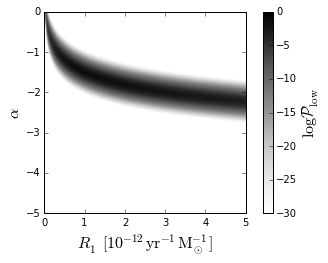

In [34]:
# VISUALIZE THE PRIOR

Nvals=200
R1_values=np.linspace(R0_limits[0],R0_limits[1],Nvals)
alpha_values=np.linspace(alpha_limits[0],alpha_limits[1],Nvals)
R1_grid,alpha_grid = np.meshgrid(R1_values, alpha_values, sparse=False)

chi2_grid=np.nan*np.ones_like(R1_grid)
logPchi2_grid=np.nan*np.ones_like(R1_grid)
for i in range(Nvals):
    for j in range(Nvals):
        chi2_grid[i,j]=chi2_low(R1_grid[i,j],alpha_grid[i,j])
        logPchi2_grid[i,j]=logP_chi2(chi2_grid[i,j],1)
        
fig=plt.figure()
plt.imshow(logPchi2_grid,origin='lower',extent=[0,5,-5,0],vmin=-30,vmax=0,cmap="Greys")
plt.xlabel(r'$R_1$ $\rm [10^{-12} yr^{-1}M_\odot^{-1}]$',fontsize=16)
plt.ylabel(r'$\alpha$',fontsize=16)
cbar=plt.colorbar(ticks=[-30,-25,-20,-15,-10,-5,0])
cbar.set_label(r'$\log \mathcal{P}_{\rm low}$',fontsize=16)
plt.subplots_adjust(bottom=0.2)


In [35]:
#  POISSON PROBABILITY OF THE SNIa COUNTS   

def log_likelihood(theta,data,grid,Nclusters,Setatau_clusters,N_obs_clusters,F_clusters,dF_clusters,z_clusters,extinction_av,extinction_rv,extinction_model,lum_cont_burst2,DL_pc_clusters,m_logscale=True):
    tau_grid,tdelay_grid,extinction_grid,m2_grid=grid

    lambda_limits=[8000,19500]
    dFmin=0.05
    
    tau_vals=theta[:Nclusters]
    t_vals=theta[Nclusters:2*Nclusters]
    av_vals=theta[2*Nclusters:3*Nclusters]
    
    if m_logscale: m2_vals=10**theta[3*Nclusters:4*Nclusters]
    else: m2_vals=theta[3*Nclusters:4*Nclusters]
    
    R0=theta[-2]
    alpha=theta[-1]
    
    RSNIa=np.nan*np.ones(Nclusters)
    NSNIa=np.nan*np.ones(Nclusters)
    for i in range(Nclusters):
        itau,taui=find_nearest(tau_vals[i],tau_grid)
        it,ti=find_nearest(t_vals[i],tdelay_grid)
        m2=m2_vals[i]
        
        age = np.where(abs(data[itau].output_age*1e-3-float(ti))==abs(data[itau].output_age*1e-3-float(ti)).min())
        i_age = age[0][0]
        
        lambda_rest=data[itau].lambda_cont
        L_rest=data[itau].lum_cont[i_age,:]
        
        ext_rest=0.*np.ones_like(lambda_rest)
        lambda_range=np.where((lambda_rest>=lambda_limits[0]/(1+z_clusters[i]))&(lambda_rest<=lambda_limits[1]/(1+z_clusters[i])))   
        ext_rest[lambda_range]=extinction(lambda_rest[lambda_range],a_v=av_vals[i],r_v=extinction_rv,model=extinction_model)

        L_rest_ext=L_rest*10**(-0.4*ext_rest)+m2*lum_cont_burst2
        
        lambda_obs=lambda_rest*(1+z_clusters[i])
        F_obs=L_rest_ext/(4.*np.pi*(DL_pc_clusters[i]*constants.parsec*100.)**2)/(1+z_clusters[i]) # erg/s/cm2/A/Mstar
        
        # F105W
        filtF105W  = np.interp(lambda_obs,lambda_F105W,filt_F105W)
        filtF105W[np.where(filtF105W<1e-2)]=0
        Mformed=1.
        FmeanF105W=simps(F_obs*filtF105W,lambda_obs)/simps(filtF105W,lambda_obs)/Mformed #  10^-16 erg/s/cm2/A/Mstar
        Mstar_result_F105W=F_clusters[i,0]/FmeanF105W*1e-16*1e-13 # 10^13 Msun
        dMstar_result_F105W=Mstar_result_F105W*max(dF_clusters[i,0],dFmin*F_clusters[i,0])/F_clusters[i,0]

        # F140W
        filtF140W  = np.interp(lambda_obs,lambda_F140W,filt_F140W)
        filtF140W[np.where(filtF140W<1e-2)]=0
        Mformed=1.
        FmeanF140W=simps(F_obs*filtF140W,lambda_obs)/simps(filtF140W,lambda_obs)/Mformed #  10^-16 erg/s/cm2/A/Mstar
        Mstar_result_F140W=F_clusters[i,1]/FmeanF140W*1e-16*1e-13 # 10^13 Msun
        dMstar_result_F140W=Mstar_result_F140W*max(dF_clusters[i,1],dFmin*F_clusters[i,1])/F_clusters[i,1]
        
        # F160W
        filtF160W  = np.interp(lambda_obs,lambda_F160W,filt_F160W)
        filtF160W[np.where(filtF160W<1e-2)]=0
        Mformed=1.
        FmeanF160W=simps(F_obs*filtF160W,lambda_obs)/simps(filtF160W,lambda_obs)/Mformed #  10^-16 erg/s/cm2/A/Mstar
        Mstar_result_F160W=F_clusters[i,2]/FmeanF160W*1e-16*1e-13 # 10^13 Msun
        dMstar_result_F160W=Mstar_result_F160W*max(dF_clusters[i,2],dFmin*F_clusters[i,2])/F_clusters[i,2]

        Mstar_array=np.array([Mstar_result_F105W,Mstar_result_F140W,Mstar_result_F160W])
        dMstar_array=np.array([dMstar_result_F105W,dMstar_result_F140W,dMstar_result_F160W])
        
        weights=1./dMstar_array**2
        nonan_indices = np.where(np.logical_not(np.isnan(Mstar_array)))[0]
        Mstar_result=np.average(Mstar_array[nonan_indices], weights=weights[nonan_indices])
        
        RSNIa[i]=Mstar_result*R0*10*(Rt(1.,1.,ti,taui/1e3,alpha)+m2*Rt(1.,1.,0.1,0.1,alpha)) #yr-1
        NSNIa[i]=RSNIa[i]*Setatau_clusters[i]

    return np.nansum(logP_Poisson(N_obs_clusters,NSNIa))
    

In [40]:
# CHI-2 PROBABILITY ASSOCIATED TO THE SFH PARAMETERS

def log_Pchi2(theta,data,Nclusters,F_clusters,dF_clusters,z_clusters,extinction_av,extinction_rv,extinction_model,lum_cont_burst2,DL_pc_clusters,m_logscale=True):
    
    lambda_limits=[8000,19500]
    dFmin=0.05
    
    tau_vals=theta[:Nclusters]
    t_vals=theta[Nclusters:2*Nclusters]
    av_vals=theta[2*Nclusters:3*Nclusters]
    
    if m_logscale: m2_vals=10**theta[3*Nclusters:4*Nclusters]
    else: m2_vals=theta[3*Nclusters:4*Nclusters]
    
    logPchi=np.nan*np.ones(Nclusters)
    for i in range(Nclusters):
        itau,taui=find_nearest(tau_vals[i],tau_grid)
        it,ti=find_nearest(t_vals[i],tdelay_grid)
        m2=m2_vals[i]
        
        age = np.where(abs(data[itau].output_age*1e-3-float(ti))==abs(data[itau].output_age*1e-3-float(ti)).min())
        i_age = age[0][0]
        
        lambda_rest=data[itau].lambda_cont
        L_rest=data[itau].lum_cont[i_age,:]
        
        ext_rest=0.*np.ones_like(lambda_rest)
        lambda_range=np.where((lambda_rest>=lambda_limits[0]/(1+z_clusters[i]))&(lambda_rest<=lambda_limits[1]/(1+z_clusters[i])))   
        ext_rest[lambda_range]=extinction(lambda_rest[lambda_range],a_v=av_vals[i],r_v=extinction_rv,model=extinction_model)
        
        L_rest_ext=L_rest*10**(-0.4*ext_rest)+m2*lum_cont_burst2
        
        lambda_obs=lambda_rest*(1+z_clusters[i])
        F_obs=L_rest_ext/(4.*np.pi*(DL_pc_clusters[i]*constants.parsec*100.)**2)/(1+z_clusters[i]) # erg/s/cm2/A/Mstar
        
        # F105W
        filtF105W  = np.interp(lambda_obs,lambda_F105W,filt_F105W)
        filtF105W[np.where(filtF105W<1e-2)]=0
        Mformed=1.
        FmeanF105W=simps(F_obs*filtF105W,lambda_obs)/simps(filtF105W,lambda_obs)/Mformed #  10^-16 erg/s/cm2/A/Mstar
        Mstar_result_F105W=F_clusters[i,0]/FmeanF105W*1e-16*1e-13 # 10^13 Msun
        dMstar_result_F105W=Mstar_result_F105W*max(dF_clusters[i,0],dFmin*F_clusters[i,0])/F_clusters[i,0]

        # F140W
        filtF140W  = np.interp(lambda_obs,lambda_F140W,filt_F140W)
        filtF140W[np.where(filtF140W<1e-2)]=0
        Mformed=1.
        FmeanF140W=simps(F_obs*filtF140W,lambda_obs)/simps(filtF140W,lambda_obs)/Mformed #  10^-16 erg/s/cm2/A/Mstar
        Mstar_result_F140W=F_clusters[i,1]/FmeanF140W*1e-16*1e-13 # 10^13 Msun
        dMstar_result_F140W=Mstar_result_F140W*max(dF_clusters[i,1],dFmin*F_clusters[i,1])/F_clusters[i,1]
        
        # F160W
        filtF160W  = np.interp(lambda_obs,lambda_F160W,filt_F160W)
        filtF160W[np.where(filtF160W<1e-2)]=0
        Mformed=1.
        FmeanF160W=simps(F_obs*filtF160W,lambda_obs)/simps(filtF160W,lambda_obs)/Mformed #  10^-16 erg/s/cm2/A/Mstar
        Mstar_result_F160W=F_clusters[i,2]/FmeanF160W*1e-16*1e-13 # 10^13 Msun
        dMstar_result_F160W=Mstar_result_F160W*max(dF_clusters[i,2],dFmin*F_clusters[i,2])/F_clusters[i,2]

        Mstar_array=np.array([Mstar_result_F105W,Mstar_result_F140W,Mstar_result_F160W])
        dMstar_array=np.array([dMstar_result_F105W,dMstar_result_F140W,dMstar_result_F160W])
        
        weights=1./dMstar_array**2
        nonan_indices = np.where(np.logical_not(np.isnan(Mstar_array)))[0]
        Mstar_result=np.average(Mstar_array[nonan_indices], weights=weights[nonan_indices])
        
        F105W_result=Mstar_result*FmeanF105W*1e29 # 10^-16 erg/s/cm2/A/Mstar
        F140W_result=Mstar_result*FmeanF140W*1e29 # 10^-16 erg/s/cm2/A/Mstar
        F160W_result=Mstar_result*FmeanF160W*1e29 # 10^-16 erg/s/cm2/A/Mstar
        F_result=np.array([F105W_result,F140W_result,F160W_result])
        dF_array=np.array([max(dF_clusters[i,0],dFmin*F_clusters[i,0]),max(dF_clusters[i,1],dFmin*F_clusters[i,1]),max(dF_clusters[i,2],dFmin*F_clusters[i,2])])
        
        difference=F_result-F_clusters[i]
        weights=1./dF_array**2
        chi2=np.nansum(difference**2*weights)
        
        ki=1. 
        logPchi[i]=logP_chi2(chi2,ki)
    
    return np.nansum(logPchi)


In [41]:
# TOTAL PROBABILITY ENTERING THE MCMC

def log_probability(theta,grid,Nclusters,Setatau_clusters,N_obs_clusters,R0_limits,alpha_limits,F_clusters,dF_clusters,z_clusters,extinction_av,extinction_rv,extinction_model,lum_cont_burst2,DL_pc_clusters,t1_clusters,t2_clusters,previous_data,data,lambda_B,filt_B,m_logscale=True):
    lp    = log_prior(theta,grid,Nclusters,R0_limits,alpha_limits,t1_clusters,t2_clusters,previous_data,m_logscale)
    lchi2 = log_Pchi2(theta,data,Nclusters,F_clusters,dF_clusters,z_clusters,extinction_av,extinction_rv,extinction_model,lum_cont_burst2,DL_pc_clusters,m_logscale)
    llike = log_likelihood(theta,data,grid,Nclusters,Setatau_clusters,N_obs_clusters,F_clusters,dF_clusters,z_clusters,extinction_av,extinction_rv,extinction_model,lum_cont_burst2,DL_pc_clusters,m_logscale)
    if not np.isfinite(lp):
        return -np.inf
    return lp +lchi2+llike
     
    

# 3/ INITIAL WALKER POSITIONS

In [42]:
Nparams=50
Nwalkers=500
extinction_av=0.

In [43]:
# UNIFORMLY SPREAD INITIAL WALKER POSITIONS 

random.seed(30)
pos=np.nan*np.ones((Nwalkers, Nparams))


for iw in range(Nwalkers):
    pos[iw,-2]=random.uniform(R0_limits[0],R0_limits[1])
    pos[iw,-1]=random.uniform(alpha_limits[0],alpha_limits[1])
    
    for ic in range(Nclusters): 
        pos[iw,ic]=random.uniform(limits[0][0],limits[0][1])
        pos[iw,1*Nclusters+ic]=random.uniform(t1[ic],t2[ic])
        pos[iw,2*Nclusters+ic]=random.uniform(limits[2][0],limits[2][1])
        pos[iw,3*Nclusters+ic]=random.uniform(limits[3][0],limits[3][1])
    

In [44]:
# CHECK THE INITIAL PROBABILITIES 

extinction_av=0.
for iw in range(Nwalkers)[:10]:
    logp=log_probability(pos[iw],grid,Nclusters,Setatau,N_obs,R0_limits,alpha_limits,F_clusters,dF_clusters,z,extinction_av,extinction_rv,extinction_model,lum_cont_burst2,DL_pc,t1,t2,previous_data,data,lambda_B,filt_B)
    logprior    = log_prior(pos[iw],grid,Nclusters,R0_limits,alpha_limits,t1,t2,previous_data)
    logpchi2 = log_Pchi2(pos[iw],data,Nclusters,F_clusters,dF_clusters,z,extinction_av,extinction_rv,extinction_model,lum_cont_burst2,DL_pc)
    loglike = log_likelihood(pos[iw],data,grid,Nclusters,Setatau,N_obs,F_clusters,dF_clusters,z,extinction_av,extinction_rv,extinction_model,lum_cont_burst2,DL_pc)
    print iw, logp, logprior, logpchi2, loglike

0 -32867.088278315794 -235.36664402626866 -85.00619534209241 -32546.71543894743
1 -167.11853950424538 -50.693967783537204 -98.21331275591604 -18.211258964792144
2 -158.68036765842302 -45.96124155331299 -93.35268498897634 -19.366441116133704
3 -72515.83064322823 -325.644747380189 -36.44867335357934 -72153.73722249446
4 -110.1617909970794 -3.6697789724835466 -87.06729515011769 -19.424716874478168
5 -388.3181049830825 -176.94148141411807 -80.60363546288524 -130.7729881060792
6 -33281.9567458759 -713.2362493224639 -81.9557815187116 -32486.76471503472
7 -43502.16683289221 -160.52097847468312 -125.91930858746353 -43215.72654583006
8 -1336.7108428762922 -138.7848765706335 -125.30058200301357 -1072.625384302645
9 -4739.699101637778 -54.209397903119815 -150.0351171977593 -4535.454586536899


# 4/ RUN MCMC

In [45]:
# FIRST RUN WITH 10 ITERATIONS

filename = save_folder+"mcmc_sampler.h5"
Niterations=10

# Set up the backend
backend = emcee.backends.HDFBackend(filename)
backend.reset(Nwalkers, Nparams)

sampler = emcee.EnsembleSampler(Nwalkers, Nparams, log_probability, args=(grid,Nclusters,Setatau,N_obs,R0_limits,alpha_limits,F_clusters,dF_clusters,z,extinction_av,extinction_rv,extinction_model,lum_cont_burst2,DL_pc,t1,t2,previous_data,data,lambda_B,filt_B),backend=backend)
sampler.run_mcmc(pos, Niterations, progress=True);

  0%|          | 0/10 [00:00<?, ?it/s]/vol/sci/astro/home/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10
/vol/sci/astro/home/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater
/vol/sci/astro/home/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


In [46]:
samples = sampler.get_chain()
flat_samples = sampler.get_chain(discard=0, thin=1, flat=True)
print np.shape(samples)

(10, 500, 50)


In [ ]:
# RUN LARGE NUMBER OF ITERATIONS

pos=samples[-1]
max_n = 500000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(pos, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau


  0%|          | 2/500000 [01:10<4889:50:55, 35.21s/it]

# 5/ MCMC RESULTS

In [49]:
mcmc_R0 = np.percentile(samples_all[90000:100000,:,-2].flatten(), [16, 50, 84])
q_R0 = np.diff(mcmc_R0)

mcmc_alpha = np.percentile(samples_all[90000:100000,:,-1].flatten(), [16, 50, 84])
q_alpha = np.diff(mcmc_alpha)

print "Average DTD parameters:", mcmc_R0[1], mcmc_alpha[1]

Average DTD parameters: 0.40605848875529954 -1.0933189990746488


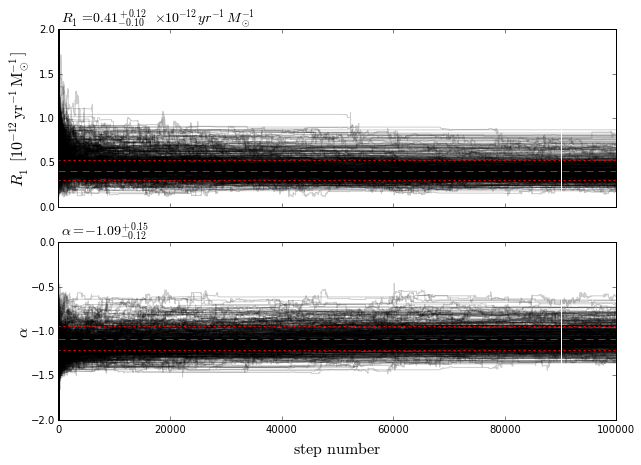

In [52]:
fontsize=16

######### R, alpha ##########
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
labels = [r"$R_1$ $\rm [10^{-12} yr^{-1}M_\odot^{-1}]$", r"$\alpha$"]
for i in range(2):
    ax = axes[i]
    ax.set_rasterized(True)
    ax.plot(samples_all[:100000, :, -2+i], "k", alpha=0.2)
    ax.set_xlim(0, len(samples_all[:100000]))
    ax.set_ylabel(labels[i],fontsize=fontsize)
    ax.yaxis.set_label_coords(-0.05, 0.5)
    ax.axvline(90000,color='w')
    ax.axvline(100000,color='w')

axes[0].text(0.005,1.04,r'$R_1=%.2f_{-%.2f}^{+%.2f}$ $ \times 10^{-12} yr^{-1}M_\odot^{-1}$'%(mcmc_R0[1], q_R0[0], q_R0[1]),color='k',transform=axes[0].transAxes,fontsize=14,zorder=2)
axes[1].text(0.005,1.04,r'$\alpha=%.2f_{-%.2f}^{+%.2f}$'%(mcmc_alpha[1], q_alpha[0], q_alpha[1]),color='k',transform=axes[1].transAxes,fontsize=14,zorder=2)

axes[0].axhline(mcmc_R0[1],color='r',ls='--',dashes=(7,5))
axes[0].axhline(mcmc_R0[1]+q_R0[1],color='r',ls='--',dashes=(2,3))
axes[0].axhline(mcmc_R0[1]-q_R0[0],color='r',ls='--',dashes=(2,3))


axes[1].axhline(mcmc_alpha[1],color='r',ls='--',dashes=(7,5))#,lw=1.5)
axes[1].axhline(mcmc_alpha[1]+ q_alpha[1],color='r',ls='--',dashes=(2,3))#,lw=1.5)
axes[1].axhline(mcmc_alpha[1]-q_alpha[0],color='r',ls='--',dashes=(2,3))#,lw=1.5)

axes[0].set_ylim([0,2])
axes[1].set_ylim([-2,0])

axes[1].set_xlabel(r"$\rm step$ $\rm number$", fontsize=fontsize)


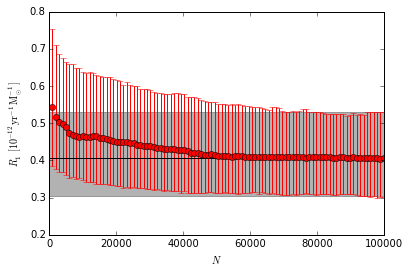

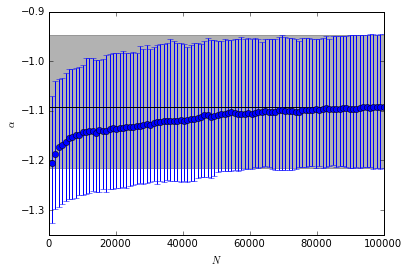

In [55]:
Ntot=np.shape(samples_all[:100000])[0]
N = np.linspace(0,Ntot-1,100).astype(int)[1:]
abscisse=np.linspace(0,Ntot,100)

plt.figure()
plt.xlabel(r'$N$')
plt.ylabel(r'$R_1$ $\rm [10^{-12} yr^{-1}M_\odot^{-1}]$')
plt.xlim([-1,Ntot])
plt.axhline(mcmc_R0[1],c='k')
plt.fill_between(abscisse,(mcmc_R0[1]-q_R0[0])*np.ones_like(abscisse),(mcmc_R0[1]+q_R0[1])*np.ones_like(abscisse),color='k',alpha=0.3)

for i in N:
    Ri = np.percentile(samples_all[i,:,-2], [16, 50, 84])
    ai = np.percentile(samples_all[i,:,-1], [16, 50, 84])    
    dRi=np.diff(Ri)
    dai=np.diff(ai)
    plt.errorbar(i,Ri[1],yerr=[[dRi[0]],[dRi[1]]],color='r',marker='o')

plt.figure()
plt.xlabel(r'$N$')
plt.ylabel(r'$\alpha$')
plt.xlim([-1,Ntot])
plt.axhline(mcmc_alpha[1],c='k')
plt.fill_between(abscisse,(mcmc_alpha[1]-q_alpha[0])*np.ones_like(abscisse),(mcmc_alpha[1]+q_alpha[1])*np.ones_like(abscisse),color='k',alpha=0.3)

for i in N:
    Ri = np.percentile(samples_all[i,:,-2], [16, 50, 84])
    ai = np.percentile(samples_all[i,:,-1], [16, 50, 84])    
    dRi=np.diff(Ri)
    dai=np.diff(ai)

    plt.errorbar(i,ai[1],yerr=[[dai[0]],[dai[1]]],color='b',marker='o')



In [60]:
flat_samples_all=samples_all.reshape(np.shape(samples_all)[0]*np.shape(samples_all)[1],np.shape(samples_all)[2])


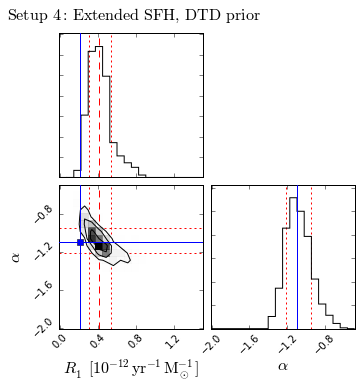

In [59]:
# DTD CORNER PLOT

field_R0=0.21
field_alpha=-1.1
field_DTD=[field_R0,field_alpha]
box=[[-0.01,1.51],[-2.01,-0.49]]

fig = corner(
    flat_samples_all[90000*500:100000*500,-2:], labels=[r'$R_1$ $\rm [10^{-12} yr^{-1}M_\odot^{-1}]$',r'$\alpha$'],truths=field_DTD,truth_color='b',percentiles=[mcmc_R0,mcmc_alpha],percentiles_color='r',range=box,plot_datapoints=False,fontsize=16,figsize=(10,7)
) 

plt.suptitle(r'$\rm Setup$ $\rm 4:$ $\rm Extended$ $\rm SFH,$ $\rm DTD$ $\rm prior$',fontsize=16,ha='left',x=0.05,y=0.995)


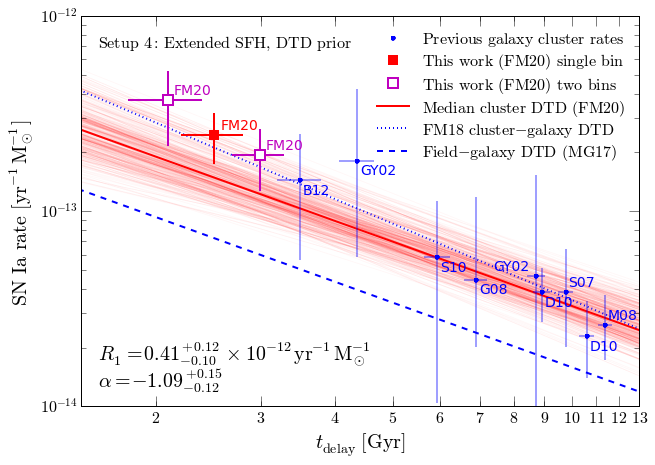

In [61]:
# DTD PLOT

fontsize=20
abscisse=np.linspace(1,13,100)

plt.figure(figsize=(10,7))
plt.clf()
ax=plt.gca()

plt.xlabel(r'$t_{\rm delay}$ $\rm [Gyr]$',fontsize=fontsize)
plt.ylabel(r'$\rm SN$ $\rm Ia$ $\rm rate$ $\rm [yr^{-1} M_\odot^{-1}]$',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize-4,length=10)
ax.tick_params(axis='both', which='minor', length=5)

# PREVIOUS
markers, caps, bars=ax.errorbar((previous_t1+previous_t2)/2.,R_previous_updated2,xerr=0.3,yerr=[dRlow_previous_updated2,dRhigh_previous_updated2],ls='', ecolor='b',elinewidth=1.5,marker='.',markersize=10,mfc='b',fmt='o',mew=0,zorder=3,label=r'$\rm Previous$ $\rm galaxy$ $\rm cluster$ $\rm rates$')
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

for i in range(np.size(t_previous)):
    if i==0:
        xr=1.015
        yr=1.07
    if i==4:#GY02
        xr=0.85
        yr=1.07
    elif i==6:
        xr=1.015
        yr=1.07
    elif i==8:
        xr=1.015
        yr=1.07
    else:
        xr=1.015
        yr=0.85        
    
    ax.text((previous_t1[i]+previous_t2[i])/2.*xr,R_previous_updated2[i]*yr,name_previous[i],fontsize=14,color='b',zorder=4)
    

# Freundlich & Maoz (2020) revised fluxes 
ax.errorbar(t_all,R_all,xerr=dt_all,yerr=dR_all,ecolor='r',ls='',elinewidth=2,marker='s',markersize=10,mfc='r',mew=0,zorder=6,label=r'$\rm This$ $\rm work$ $\rm (FM20)$ $\rm single$ $\rm bin$')
markers, caps_low, bars=ax.errorbar(t_low,R_low,xerr=dt_low,yerr=dR_low,ls='',ecolor='m',elinewidth=2,marker='s',markersize=10,mfc='w',mew=2,mec='m',zorder=6,label=r'$\rm This$ $\rm work$ $\rm (FM20)$ $\rm two$ $\rm bins$')
markers, caps_high, bars=ax.errorbar(t_high,R_high,xerr=dt_high,yerr=dR_high,ls='',ecolor='m',elinewidth=2,marker='s',markersize=10,mfc='w',mew=2,mec='m',zorder=6)
[cap.set_alpha(0) for cap in caps_low]
[cap.set_alpha(0) for cap in caps_high]

xr=1.03
yr=1.07
ax.text(t_all*xr,R_all*yr,'FM20',fontsize=14,color='r',zorder=7)
ax.text(t_low*xr,R_low*yr,'FM20',fontsize=14,color='m',zorder=7)
ax.text(t_high*xr,R_high*yr,'FM20',fontsize=14,color='m',zorder=7)

# LINES
inds = np.random.randint(90000*500,100000*500, size=500)
for ind in inds:
    sample = flat_samples_all[ind]
    R0=sample[-2]
    alpha=sample[-1]
    plt.plot(abscisse, 10**(np.log10(R0)-12+alpha*np.log10(abscisse)), 'r',alpha=0.03,zorder=0)

plt.plot(abscisse, 10**(np.log10(mcmc_R0[1])-12+mcmc_alpha[1]*np.log10(abscisse)), 'r',ls='-',lw=2,alpha=1,zorder=2,label=r'$\rm Median$ $\rm cluster$ $\rm DTD$ $\rm (FM20)$')
plt.plot(abscisse, 10**(np.log10(0.7)-12-1.3*np.log10(abscisse)), 'b',ls=':',lw=2,alpha=1,zorder=2,label=r'$\rm FM18$ $\rm cluster-galaxy$ $\rm DTD$')
plt.plot(abscisse, 10**(np.log10(0.2)-12-1.1*np.log10(abscisse)), 'b',ls='--',lw=2,alpha=1,zorder=1,label=r'$\rm Field-galaxy$ $\rm DTD$ $\rm (MG17)$')

plt.loglog()
ax.set_xticks(np.linspace(1,13,13))
ax.set_xticklabels([r'$%.0f$'%ii for ii in np.linspace(1,13,13)])
ax.set_yticks([1e-14,1e-13,1e-12])
ax.set_yticklabels([r'$10^{%.0f}$'%ii for ii in [-14,-13,-12]])

ax.axis([1.5,13,1e-14,1e-12])

handles, labels = ax.get_legend_handles_labels()
handles=[handles[3][0],handles[4][0],handles[5][0],handles[0],handles[1],handles[2]]
labels=[labels[3],labels[4],labels[5],labels[0],labels[1],labels[2]]
ax.legend(handles, labels,loc='upper right',frameon=False,fontsize=fontsize-4,numpoints=1,labelspacing=.2)

ax.text(0.03,0.12,r'$R_1=%.2f_{-%.2f}^{+%.2f} \times$ $10^{-12} \rm yr^{-1}M_\odot^{-1}$'%(mcmc_R0[1], q_R0[0], q_R0[1]),color='k',fontsize=fontsize,transform=ax.transAxes)
ax.text(0.03,0.05,r'$\alpha=%.2f_{-%.2f}^{+%.2f}$'%(mcmc_alpha[1], q_alpha[0], q_alpha[1]),color='k',fontsize=fontsize,transform=ax.transAxes)

ax.text(0.03,0.92,r'$\rm Setup$ $\rm 4:$ $\rm Extended$ $\rm SFH,$ $\rm DTD$ $\rm prior$',color='k',fontsize=fontsize-4,transform=ax.transAxes)


# 6/ Asymptotical formed steller mass M0 and predicted number Npred

In [62]:

lambda_limits=[8000,19500]
dFmin=0.05
m_logscale=True
z_clusters=z
LB_sun=4.9e29 # erg/s/A

Nstat=500
inds = np.random.randint(90000*500,100000*500, size=Nstat)

Mstar_inds=np.nan*np.ones((Nstat,Nclusters))
Npred_inds=np.nan*np.ones((Nstat,Nclusters))
RSNIa_M_inds=np.nan*np.ones((Nstat,Nclusters))
RSNIa_L_inds=np.nan*np.ones((Nstat,Nclusters))
F105W_inds=np.nan*np.ones((Nstat,Nclusters))
F140W_inds=np.nan*np.ones((Nstat,Nclusters))
F160W_inds=np.nan*np.ones((Nstat,Nclusters))

for iind,ind in enumerate(inds):

    sample = flat_samples_all[ind]
    tau_vals=sample[:Nclusters]
    t_vals=sample[Nclusters:2*Nclusters]
    av_vals=sample[2*Nclusters:3*Nclusters]
    
    if m_logscale: m2_vals=10**sample[3*Nclusters:4*Nclusters]
    else: m2_vals=sample[3*Nclusters:4*Nclusters]
    
    R0=sample[-2]
    alpha=sample[-1]
    
    for i in range(Nclusters):
        itau,taui=find_nearest(tau_vals[i],tau_grid)
        it,ti=find_nearest(t_vals[i],tdelay_grid)
        m2=m2_vals[i]
        
        age = np.where(abs(data[itau].output_age*1e-3-float(ti))==abs(data[itau].output_age*1e-3-float(ti)).min())
        i_age = age[0][0]
        
        lambda_rest=data[itau].lambda_cont
        L_rest=data[itau].lum_cont[i_age,:]
        
        ext_rest=0.*np.ones_like(lambda_rest)
        lambda_range=np.where((lambda_rest>=lambda_limits[0]/(1+z[i]))&(lambda_rest<=lambda_limits[1]/(1+z[i])))   
        ext_rest[lambda_range]=extinction(lambda_rest[lambda_range],a_v=av_vals[i],r_v=extinction_rv,model=extinction_model)

        L_rest_ext=L_rest*10**(-0.4*ext_rest)+m2*lum_cont_burst2
        
        lambda_obs=lambda_rest*(1+z[i])
        F_obs=L_rest_ext/(4.*np.pi*(DL_pc[i]*constants.parsec*100.)**2)/(1+z[i]) # erg/s/cm2/A/Mstar
        
        # F105W
        filtF105W  = np.interp(lambda_obs,lambda_F105W,filt_F105W)
        filtF105W[np.where(filtF105W<1e-2)]=0
        Mformed=1.
        FmeanF105W=simps(F_obs*filtF105W,lambda_obs)/simps(filtF105W,lambda_obs)/Mformed #  10^-16 erg/s/cm2/A/Mstar
        Mstar_result_F105W=F_clusters[i,0]/FmeanF105W*1e-16*1e-13 # 10^13 Msun
        dMstar_result_F105W=Mstar_result_F105W*max(dF_clusters[i,0],dFmin*F_clusters[i,0])/F_clusters[i,0]

        # F140W
        filtF140W  = np.interp(lambda_obs,lambda_F140W,filt_F140W)
        filtF140W[np.where(filtF140W<1e-2)]=0
        Mformed=1.
        FmeanF140W=simps(F_obs*filtF140W,lambda_obs)/simps(filtF140W,lambda_obs)/Mformed #  10^-16 erg/s/cm2/A/Mstar
        Mstar_result_F140W=F_clusters[i,1]/FmeanF140W*1e-16*1e-13 # 10^13 Msun
        dMstar_result_F140W=Mstar_result_F140W*max(dF_clusters[i,1],dFmin*F_clusters[i,1])/F_clusters[i,1]
        
        # F160W
        filtF160W  = np.interp(lambda_obs,lambda_F160W,filt_F160W)
        filtF160W[np.where(filtF160W<1e-2)]=0
        Mformed=1.
        FmeanF160W=simps(F_obs*filtF160W,lambda_obs)/simps(filtF160W,lambda_obs)/Mformed #  10^-16 erg/s/cm2/A/Mstar
        Mstar_result_F160W=F_clusters[i,2]/FmeanF160W*1e-16*1e-13 # 10^13 Msun
        dMstar_result_F160W=Mstar_result_F160W*max(dF_clusters[i,2],dFmin*F_clusters[i,2])/F_clusters[i,2]

        Mstar_array=np.array([Mstar_result_F105W,Mstar_result_F140W,Mstar_result_F160W])
        dMstar_array=np.array([dMstar_result_F105W,dMstar_result_F140W,dMstar_result_F160W])
        
        weights=1./dMstar_array**2
        nonan_indices = np.where(np.logical_not(np.isnan(Mstar_array)))[0]
        Mstar_inds[iind,i]=np.average(Mstar_array[nonan_indices], weights=weights[nonan_indices])
         
        F105W_inds[iind,i]=Mstar_inds[iind,i]*FmeanF105W*1e29 # 10^-16 erg/s/cm2/A/Mstar
        F140W_inds[iind,i]=Mstar_inds[iind,i]*FmeanF140W*1e29 # 10^-16 erg/s/cm2/A/Mstar
        F160W_inds[iind,i]=Mstar_inds[iind,i]*FmeanF160W*1e29 # 10^-16 erg/s/cm2/A/Mstar

        RSNIa=Mstar_inds[iind,i]*R0*10*(Rt(1.,1.,t_vals[i],tau_vals[i]/1e3,alpha)+m2*Rt(1.,1.,0.1,0.1,alpha)) #yr-1
        RSNIa_M_inds[iind,i]=RSNIa
        Npred_inds[iind,i]=RSNIa*Setatau[i]
        
        lambda_rest_limits=[3000,7000]
        lambda_rest_range=np.where((lambda_rest>=lambda_rest_limits[0])&(lambda_rest<=lambda_rest_limits[1]))   
        lambda_B_range=np.where((lambda_B>=lambda_rest_limits[0])&(lambda_B<=lambda_rest_limits[1])) 
                
        filtB=interp1d(lambda_B[lambda_B_range],filt_B[lambda_B_range])(lambda_rest[lambda_rest_range])
        filtB[np.where(filtB<1e-2)]=0
        Mformed=1.
        L_B=simps(L_rest[lambda_rest_range]*filtB,lambda_rest[lambda_rest_range])/simps(filtB,lambda_rest[lambda_rest_range])/Mformed #  erg/s/A/Mstar
        
        RSNIa_L_inds[iind,i]=RSNIa/L_B*LB_sun # 10-12 yr-1 Lsun-1

        

Table
 
IDCS1426   M0=0.84-0.35+0.35 Npred_ind=1.6-0.6+1.0 (Nobs=1.5)
ISCS1432   M0=1.24-0.33+0.33 Npred_ind=1.7-0.5+0.9 (Nobs=1.0)
MOO1014    M0=1.49-0.42+0.42 Npred_ind=2.3-0.7+1.5 (Nobs=2.0)
MOO1142    M0=2.09-0.55+0.55 Npred_ind=1.1-0.4+0.6 (Nobs=0.0)
SPARCS0224 M0=1.05-0.38+0.38 Npred_ind=0.8-0.3+0.6 (Nobs=1.5)
SPARCS0330 M0=0.78-0.32+0.32 Npred_ind=1.0-0.4+0.7 (Nobs=0.5)
SPARCS1049 M0=1.01-0.35+0.35 Npred_ind=0.5-0.2+0.3 (Nobs=0.0)
SPARCS0035 M0=1.34-0.31+0.31 Npred_ind=1.5-0.5+0.6 (Nobs=0.5)
SPT0205    M0=1.59-0.38+0.38 Npred_ind=2.8-0.8+1.6 (Nobs=4.5)
SPT2040    M0=2.31-0.73+0.73 Npred_ind=3.3-1.2+1.3 (Nobs=3.0)
SPT2106    M0=1.03-0.31+0.31 Npred_ind=1.9-0.7+1.1 (Nobs=1.0)
XMM44      M0=1.87-0.54+0.54 Npred_ind=1.2-0.5+0.7 (Nobs=1.0)
 
Total      M0=17.63-1.87+2.15 Npred_ind=20.6-5.0+5.0 (Nobs=16.5)


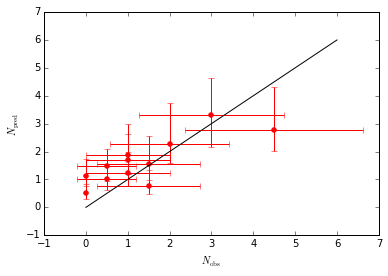

In [64]:

M0_percentiles=np.percentile(Mstar_inds, [16, 50, 84],axis=0)

Ntot_inds=np.sum(Npred_inds,axis=1)
Mtot_inds=np.sum(Mstar_inds,axis=1)

Npred_ind_percentiles=np.percentile(Npred_inds, [16, 50, 84],axis=0)
dNpred_ind_n=Npred_ind_percentiles[1]*np.sqrt((np.diff(Npred_ind_percentiles,axis=0)[0]/Npred_ind_percentiles[1])**2)#+(np.diff(mcmc_R0)[0]/mcmc_R0[1])**2)
dNpred_ind_p=Npred_ind_percentiles[1]*np.sqrt((np.diff(Npred_ind_percentiles,axis=0)[1]/Npred_ind_percentiles[1])**2)#+(np.diff(mcmc_R0)[1]/mcmc_R0[1])**2)

Ntot_ind_percentiles=np.percentile(Ntot_inds, [16, 50, 84],axis=0)
dNtot_ind_n=Ntot_ind_percentiles[1]*np.sqrt((np.diff(Ntot_ind_percentiles,axis=0)[0]/Ntot_ind_percentiles[1])**2)#+(np.diff(mcmc_R0)[0]/mcmc_R0[1])**2)
dNtot_ind_p=Ntot_ind_percentiles[1]*np.sqrt((np.diff(Ntot_ind_percentiles,axis=0)[1]/Ntot_ind_percentiles[1])**2)#+(np.diff(mcmc_R0)[1]/mcmc_R0[1])**2)

Mtot_ind_percentiles=np.percentile(Mtot_inds, [16, 50, 84],axis=0)

print 'Table'
print ' '
for ic in range(Nclusters):
    print '%-10s'%name[ic], 
    print 'M0=%.2f-%.2f+%.2f'%(M0_percentiles[1,ic],np.diff(M0_percentiles,axis=0)[0][ic],np.diff(M0_percentiles,axis=0)[0][ic]),
    print 'Npred_ind=%.1f-%.1f+%.1f'%(Npred_ind_percentiles[1,ic],dNpred_ind_n[ic],dNpred_ind_p[ic]),
    print '(Nobs=%.1f)'%N_obs[ic]

print ' '
print '%-10s'%('Total'),
print 'M0=%.2f-%.2f+%.2f'%(Mtot_ind_percentiles[1],np.diff(Mtot_ind_percentiles,axis=0)[0],np.diff(Mtot_ind_percentiles,axis=0)[1]),
print 'Npred_ind=%.1f-%.1f+%.1f'%(Ntot_ind_percentiles[1],dNtot_ind_n,dNtot_ind_n),
print '(Nobs=%.1f)'%(sum(N_obs))

plt.figure()
abscisse=np.linspace(0,6,100)
plt.plot(abscisse,abscisse,'k')
plt.errorbar(N_obs, Npred_ind_percentiles[1],ecolor='r',xerr=np.sqrt(N_obs),yerr=[dNpred_ind_n,dNpred_ind_p],label=r'$N_{\rm pred, ind}$',fmt=None)
plt.scatter(N_obs, Npred_ind_percentiles[1],color='r')
plt.xlabel(r'$N_{\rm obs}$')
plt.ylabel(r'$N_{\rm pred}$')


# 7/ REJECTING THE FIELD DTD

In [67]:
Nstat=500
Nbootstrap=10

In [68]:
flat_samples=flat_samples_all[90000*500:100000*500]
fake_samples=flat_samples.copy()

In [70]:
# CHECK: FINAL PROBABILITIES // SFH PARAMETERS FROM MCMC
# compares the max probability in the MCMC output (with best R1, alpha) 
# to the max probability with R1_field, alpha_field
# -- using Wilks' theorem

alpha_val=-1.1
R0_val=0.21

fake_samples[:,-2]=R0_val
fake_samples[:,-1]=alpha_val

logp_inds=np.nan*np.ones((Nbootstrap,Nstat))
logp_val_inds=np.nan*np.ones((Nbootstrap,Nstat))

for i_bootstrap in range(Nbootstrap):
    #print '%i/%i'%(i_bootstrap,Nbootstrap-1)
    inds = np.random.randint(0,len(flat_samples), size=Nstat)

    for iind,ind in enumerate(inds):

        logp_inds[i_bootstrap,iind]=log_probability(flat_samples[ind],grid,Nclusters,Setatau,N_obs,R0_limits,alpha_limits,F_clusters,dF_clusters,z,extinction_av,extinction_rv,extinction_model,lum_cont_burst2,DL_pc,t1,t2,previous_data,data,lambda_B,filt_B)
        logp_val_inds[i_bootstrap,iind]=log_probability(fake_samples[ind],grid,Nclusters,Setatau,N_obs,R0_limits,alpha_limits,F_clusters,dF_clusters,z,extinction_av,extinction_rv,extinction_model,lum_cont_burst2,DL_pc,t1,t2,previous_data,data,lambda_B,filt_B)

logp_cluster_max=logp_inds.max()
logp_val_max=logp_val_inds.max()
D=2*(logp_cluster_max-logp_val_max)

print "max cluster logP =", logp_cluster_max
print "max val     logP =", logp_val_max
print "distance %.2f-sigma"%np.sqrt(D)

# GET PROBABILITY 

N_freedom=2

x=np.linspace(1e-4,100,1e4)
logP_chisquare_x=logP_chi2(x,N_freedom)

P_D=P_chi2(D,N_freedom)
logP_D=logP_chi2(D,N_freedom)

ip=np.where(abs(logP_D-logP_chisquare_x)==abs(logP_D-logP_chisquare_x).min())[0]
chisquare=x[ip][0]
chi=np.sqrt(chisquare)

print 'Nfreedom=%i: '%N_freedom, 'P=%.2e, '%P_D, 'logP=%.2f, '%logP_D, 'i.e., %.2f-sigma'%chi, 'D=%.2f'%D,'sqrt(D)=%.2f'%np.sqrt(D)

max cluster logP = -1.5577084812041981
max val     logP = -8.629631935230318
distance 3.76-sigma
Nfreedom=2:  P=4.24e-04,  logP=-7.77,  i.e., 3.76-sigma D=14.14 sqrt(D)=3.76


/vol/sci/astro/home/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


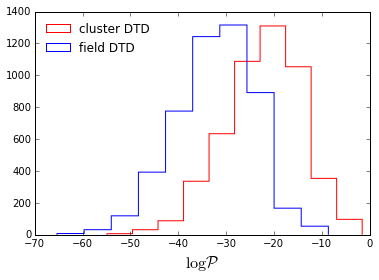

In [71]:
flat_logp_inds=logp_inds.flatten()
flat_logp_val_inds=logp_val_inds.flatten()

plt.hist(flat_logp_inds,histtype='step',color='r',label=r'cluster DTD')
plt.hist(flat_logp_val_inds,histtype='step',color='b',label=r'field DTD')
plt.xlabel(r'$\log \mathcal{P}$',fontsize=16)
plt.legend(loc='upper left',frameon=False)
